In [1]:
!pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.


In [2]:
!pip install gdown

In [3]:
!gdown --id 1iCAFN2MIkngxldIvM940UA0InYtl6tJb

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1iCAFN2MIkngxldIvM940UA0InYtl6tJb
From (redirected): https://drive.google.com/uc?id=1iCAFN2MIkngxldIvM940UA0InYtl6tJb&confirm=t&uuid=c05ab19b-fd87-4a6e-914d-7e8047d88ed9
To: /kaggle/working/merge.zip
100%|████████████████████████████████████████| 123M/123M [00:04<00:00, 25.3MB/s]


In [4]:
!unzip /kaggle/working/merge.zip -d /kaggle/working/datasets

Archive:  /kaggle/working/merge.zip
   creating: /kaggle/working/datasets/merge/
   creating: /kaggle/working/datasets/merge/images/
   creating: /kaggle/working/datasets/merge/images/train/
  inflating: /kaggle/working/datasets/merge/images/train/crop_0.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_1.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_10.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_11.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_12.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_13.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_14.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_15.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_16.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_17.jpg  
  inflating: /kaggle/working/datasets/merge/images/train/crop_18.jpg  
  inflating: /kaggle/working/d

In [5]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")


2024-05-23 00:39:44.738573: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 00:39:44.738687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 00:39:44.852734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
from typing import List, NamedTuple, Tuple
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms


class Location(NamedTuple):
    center_x: float  # center_x/image_width
    center_y: float  # center_y/image_height
    width: float  # width/image_width
    height: float  # height/image_height


class Point(NamedTuple):
    x: int
    y: int


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_url_list: List[str], label_url_list: List[str], feature_extractor):
        super(CustomDataset, self).__init__()
        self.img_url_list = img_url_list
        self.label_url_list = label_url_list
        self.feature_extractor = feature_extractor
        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_url_list)

    def _get_box_location(self, string: str) -> Location:
        return Location(*map(float, string.split()[1:]))

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, List[Location]]:
        img_url = self.img_url_list[idx]
        label_url = self.label_url_list[idx]
        img = Image.open(img_url)
        with open(label_url) as f:
            bboxes = list(map(self._get_box_location, f.read().splitlines()))
        img = self.transform(img)
        target = {
            "boxes": torch.tensor(bboxes, dtype=torch.float32),
            "class_labels": torch.tensor([0] * len(bboxes), dtype=torch.int64)
        }
        return img, target
    def get_image(self, idx: int) -> Image:
        return Image.open(self.img_url_list[idx]).convert("RGB")


In [7]:
from glob import glob
train_image_url_list = glob("/kaggle/working/datasets/merge/images/train/*.jpg")
train_label_url_list = [
    url.replace("images", "labels").replace(".jpg", ".txt")
    for url in train_image_url_list
]
train_dataset = CustomDataset(train_image_url_list, train_label_url_list, feature_extractor)
len(train_dataset)

630

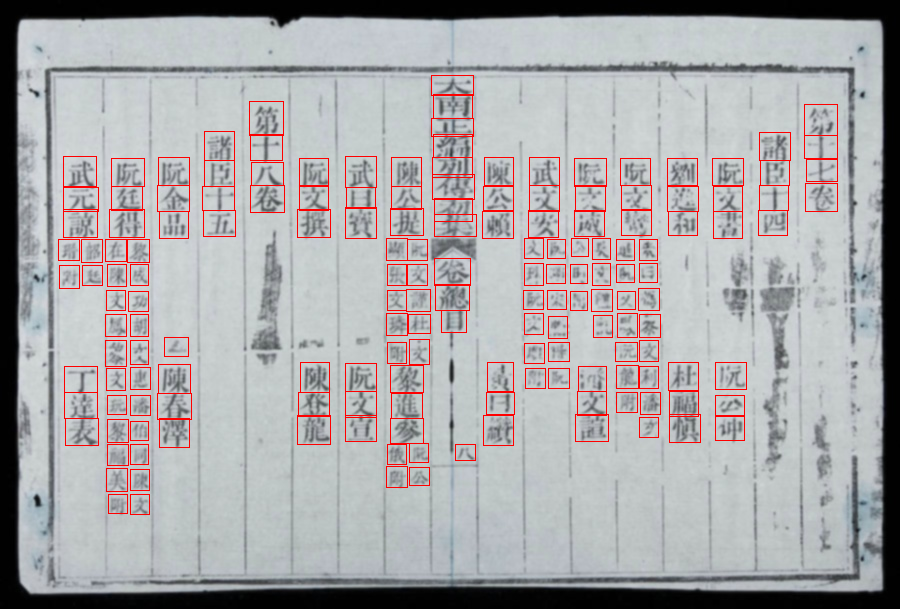

In [8]:
import numpy as np
from PIL import Image, ImageDraw

def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = dataset.get_image(idx)
    draw = ImageDraw.Draw(image)
    width, height = image.size
    for box in sample[1]["boxes"]:
        x, y, w, h = tuple(box)
        center_x = x * width
        center_y = y * height
        box_height = h * height
        box_width = w * width
        top_left = Point(int(center_x - box_width / 2), int(center_y - box_height / 2))
        bottom_right = Point(int(center_x + box_width / 2), int(center_y + box_height / 2))
        draw.rectangle((top_left.x, top_left.y, bottom_right.x, bottom_right.y), outline="red", width=1)
    return image


draw_image_from_idx(dataset=train_dataset, idx=10)

In [9]:
!ls /kaggle/working/datasets/merge/images/train | wc -l

630


In [10]:
!ls /kaggle/working/datasets/merge/labels/train | wc -l

630


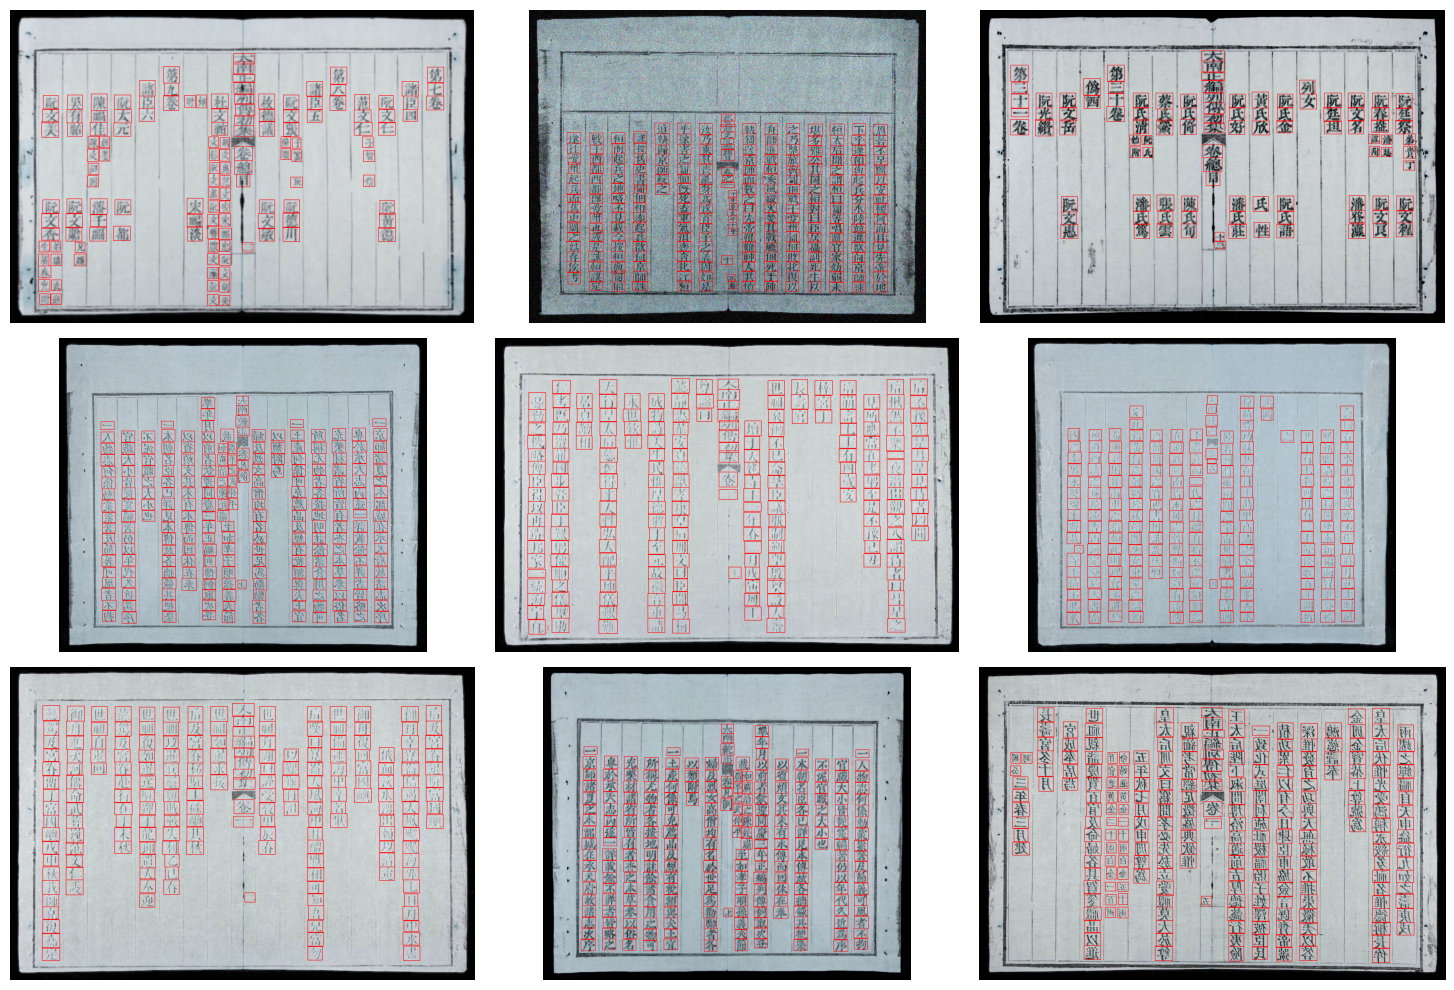

In [11]:
import matplotlib.pyplot as plt


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images

plot_images(train_dataset, range(9))

In [12]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader


def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    return images, targets

dataloader = DataLoader(train_dataset, 
                        batch_size=2, 
                        shuffle=True, 
                        collate_fn=collate_fn)

# Define optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for images, targets in dataloader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        outputs = model(images, labels=targets)

        # Compute loss
        loss = outputs.loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Step the learning rate scheduler
    lr_scheduler.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 1.2155953645706177
Epoch 2, Loss: 0.9576815366744995
Epoch 3, Loss: 1.0796504020690918
Epoch 4, Loss: 1.044102668762207
Epoch 5, Loss: 1.1624670028686523
Epoch 6, Loss: 0.8272556066513062
Epoch 7, Loss: 0.7583572268486023
Epoch 8, Loss: 0.6528775691986084
Epoch 9, Loss: 0.9691424369812012
Epoch 10, Loss: 0.7136995196342468
Epoch 11, Loss: 0.625930666923523
Epoch 12, Loss: 0.6962417364120483
Epoch 13, Loss: 1.0398553609848022
Epoch 14, Loss: 1.2513256072998047
Epoch 15, Loss: 0.8562637567520142
Epoch 16, Loss: 0.873345673084259
Epoch 17, Loss: 2.0318336486816406
Epoch 18, Loss: 0.712807834148407
Epoch 19, Loss: 1.340374231338501
Epoch 20, Loss: 1.0086722373962402
Epoch 21, Loss: 0.9076917767524719
Epoch 22, Loss: 1.6798237562179565
Epoch 23, Loss: 1.0018833875656128
Epoch 24, Loss: 1.3252322673797607
Epoch 25, Loss: 1.673069715499878
Epoch 26, Loss: 0.7934377193450928
Epoch 27, Loss: 0.8503937721252441
Epoch 28, Loss: 0.797022819519043
Epoch 29, Loss: 0.9425551891326904
E

In [13]:
model.save_pretrained("/kaggle/working/")
feature_extractor.save_pretrained("/kaggle/working/")

['/kaggle/working/preprocessor_config.json']

In [14]:
val_image_url_list = glob("/kaggle/working/datasets/merge/images/val/*.jpg")
val_label_url_list = [
    url.replace("images", "labels").replace(".jpg", ".txt")
    for url in val_image_url_list
]
val_dataset = CustomDataset(val_image_url_list, val_label_url_list, feature_extractor)
len(val_dataset)

10

In [15]:
# Evaluation code
model.eval()
validation_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
results = []
with torch.no_grad():
    for images, targets in validation_dataloader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images, labels=targets)
        # Extract bounding boxes, class labels, and confidence scores
        logits = outputs.logits
        bboxes = outputs.pred_boxes
        probs = logits.softmax(-1)[:, :, :-1]  # Exclude the last class which is the "no object" class
        scores, labels = probs.max(-1)

        # Move tensors to CPU and convert to numpy arrays
        bboxes = bboxes.cpu().numpy()
        scores = scores.cpu().numpy()
        labels = labels.cpu().numpy()
        results.append((bboxes, scores, labels))

In [16]:
print(results[0])

(array([[[0.141686  , 0.73519367, 0.04115213, 0.04351417],
        [0.5019798 , 0.46800408, 0.04098039, 0.04070997],
        [0.2931098 , 0.83110493, 0.03843516, 0.04336069],
        [0.56938297, 0.25578392, 0.04028711, 0.04460529],
        [0.39189807, 0.44184324, 0.03437607, 0.03904285],
        [0.45210034, 0.71727115, 0.03647923, 0.04286806],
        [0.4499323 , 0.61101246, 0.03679321, 0.04191209],
        [0.29127532, 0.66552377, 0.03566818, 0.03982627],
        [0.2880828 , 0.46227136, 0.03581085, 0.03893079],
        [0.2756932 , 0.4197779 , 0.03717989, 0.04225394],
        [0.70968163, 0.7488432 , 0.0364834 , 0.04159615],
        [0.16940887, 0.805891  , 0.04186209, 0.04420036],
        [0.7596378 , 0.72457916, 0.03538419, 0.0430308 ],
        [0.7618196 , 0.6550375 , 0.03559868, 0.04027359],
        [0.5320856 , 0.83285606, 0.04266968, 0.04362572],
        [0.22542827, 0.501563  , 0.03971992, 0.04222842],
        [0.18015964, 0.42753872, 0.03938694, 0.04205072],
        [0.70

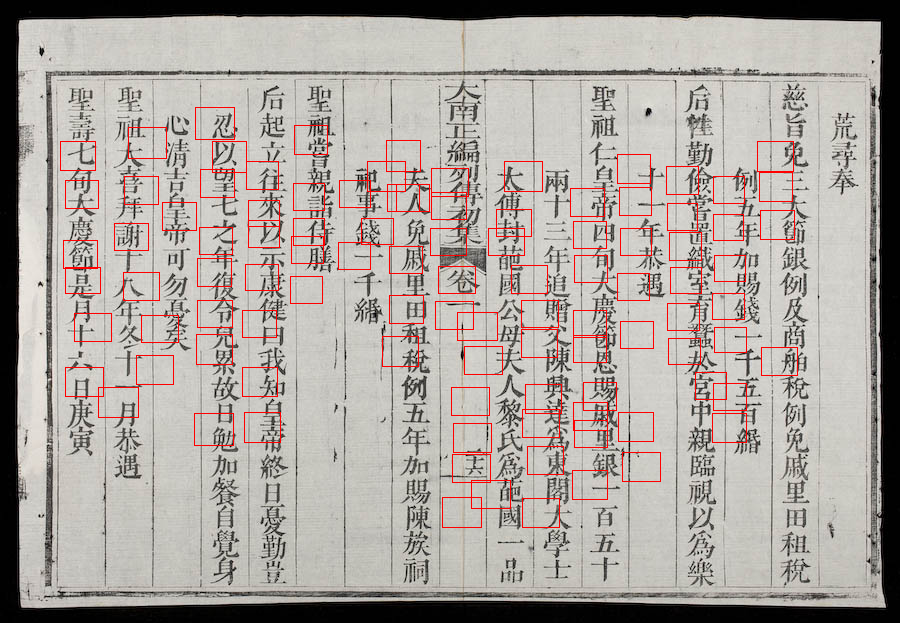

In [17]:
def draw_image_from_idx(dataset, results, idx):
    sample = dataset[idx]
    image = dataset.get_image(idx)
    draw = ImageDraw.Draw(image)
    width, height = image.size
    for box in results[idx][0][0]:
        x, y, w, h = tuple(box)
        center_x = x * width
        center_y = y * height
        box_height = h * height
        box_width = w * width
        top_left = Point(int(center_x - box_width / 2), int(center_y - box_height / 2))
        bottom_right = Point(int(center_x + box_width / 2), int(center_y + box_height / 2))
        draw.rectangle((top_left.x, top_left.y, bottom_right.x, bottom_right.y), outline="red", width=1)
        
    return image


draw_image_from_idx(dataset=val_dataset, results=results, idx=9)

In [18]:
!rm -rf lvdthieu

In [19]:
!cd /kaggle/working
!mkdir lvdthieu

In [20]:
import os
output_dir = "/kaggle/working/lvdthieu"
for idx, image_url in enumerate(val_image_url_list):
    pred_box = results[idx][0][0]
    score = results[idx][1][0]
    label = results[idx][2][0]
    file_base_name = os.path.basename(image_url.split('.jpg')[0])
    output_file = os.path.join(output_dir, file_base_name + '.txt')
    print(f"output to: {output_file}")
    with open(output_file, 'w') as f:
        for abox, ascore, alabel in zip(pred_box, score, label):
            x, y, w, h = abox
            f.write(f"{alabel} {x} {y} {w} {h} {ascore}\n")
    

output to: /kaggle/working/lvdthieu/nlvnpf-0174-03-013.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0174-03-014.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-047.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0140-01-017.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-049.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-046.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0140-01-016.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-048.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-050.txt
output to: /kaggle/working/lvdthieu/nlvnpf-0137-01-045.txt


In [21]:
!gdown --id 1izOtlgQdeQJRmlgRLxbx1kOmcKKaSkw0

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1izOtlgQdeQJRmlgRLxbx1kOmcKKaSkw0
From (redirected): https://drive.google.com/uc?id=1izOtlgQdeQJRmlgRLxbx1kOmcKKaSkw0&confirm=t&uuid=12b0b186-82ed-46b8-8ab2-d793c7d6c53d
To: /kaggle/working/task1.py
100%|██████████████████████████████████████| 13.9k/13.9k [00:00<00:00, 40.1MB/s]


In [22]:
!python task1.py --gt /kaggle/working/datasets/merge/labels/val --pred /kaggle/working/lvdthieu --img /kaggle/working/datasets/merge/images/val

4.681538402595668
3.0644989197980985
1.91256679102842
0.9768116959576303
0.4527465866640091
0.15006793150918915
0.04683135155215847
0.006144728661084132
0.0008030064561719076
0.0
0.01129200941422243
